In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [34]:
# hyperparams
input_channels = 1
hidden_channels = 64 * 2
n_epochs = 20
batch_size = int(128 / 2)

device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.',
                               train=True,
                               download=True,
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

dataset_test = datasets.MNIST('.',
                              train=False,
                              download=True,
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last = True,)

In [36]:
def train_model(train_dataloader, model):
  train_loss = 0

  model.train()
    
  for i, batch in enumerate(train_dataloader):
    inputs, labels = batch
    optim.zero_grad()

    predict = model(inputs.to(device))
    loss = loss_func(inputs.to(device), predict)

    loss.backward()
    optim.step()

    train_loss += loss.item()

  return train_loss

In [37]:
def validate_model(test_dataloader, model):
  test_loss = 0

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        inputs, labels = batch
        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)

        test_loss += loss.item()

  return test_loss

**Задание1 - обучить AE собственной архитектуры**

In [42]:
class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1,padding=2)    
    self.do1 = nn.Dropout(0.1)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do2 = nn.Dropout(0.2)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14    
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do3 = nn.Dropout(0.2)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do4 = nn.Dropout(0.2)
    self.bn4 = nn.BatchNorm2d(hidden_ch)
    
    self.pool2 = nn.MaxPool2d((2, 2)) # 7 x 7 = 49
    
    self.conv5 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1)
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.bn1(self.conv1(x))))
    x = self.pool1(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.do3(self.activ(self.bn3(self.conv3(x))))
    x = self.pool2(self.do4(self.bn4(self.activ(self.conv4(x)))))

    return self.conv5(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do1 = nn.Dropout(0.2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)  
    self.do2 = nn.Dropout(0.1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14

    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do3 = nn.Dropout(0.2)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    
    self.conv4 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, padding=2)
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.bn1(self.conv1(x))))
    x = self.upsample1(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.upsample2(self.do3(self.activ(self.bn3(self.conv3(x)))))

    return self.conv4(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [43]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.L1Loss() #TODO try to use MAE


Epoch [1/20], Train Loss: 0.1416, Val Loss: 0.1151


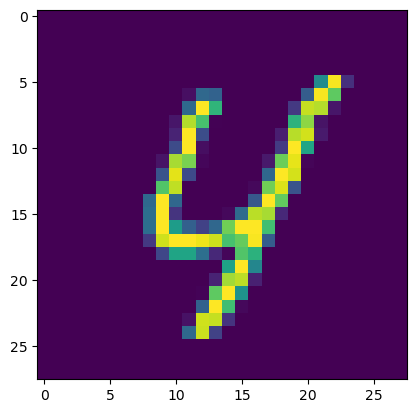

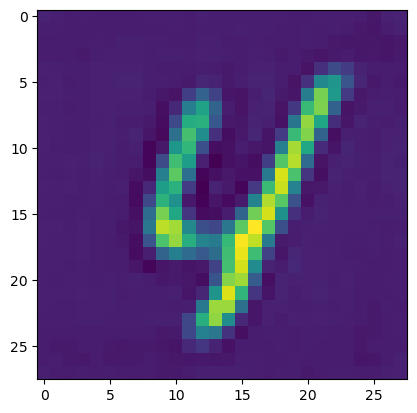

Epoch [2/20], Train Loss: 0.1039, Val Loss: 0.0834


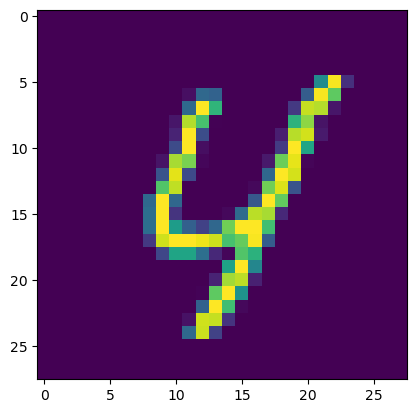

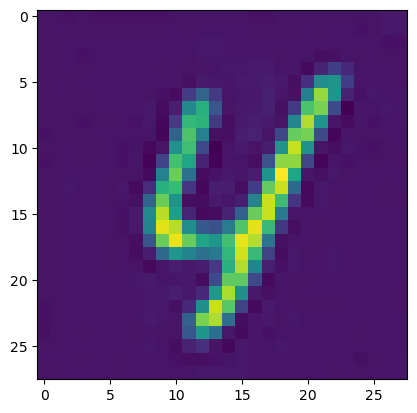

Epoch [3/20], Train Loss: 0.0961, Val Loss: 0.0811


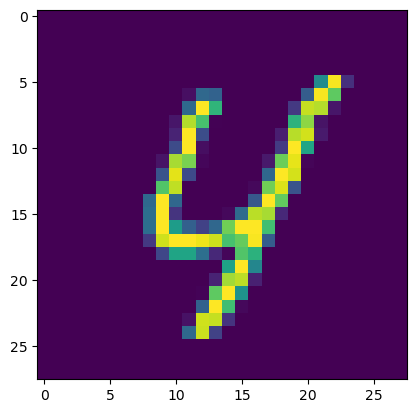

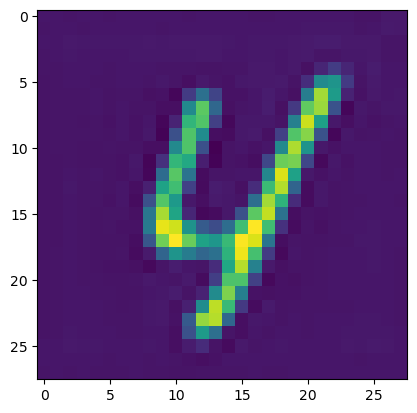

Epoch [4/20], Train Loss: 0.0912, Val Loss: 0.0876


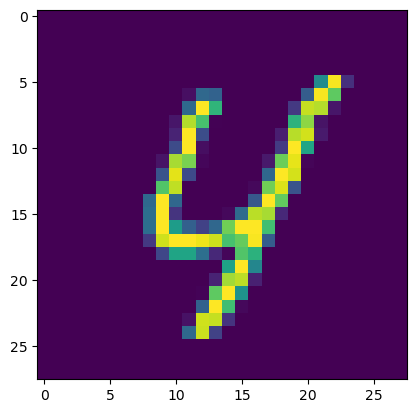

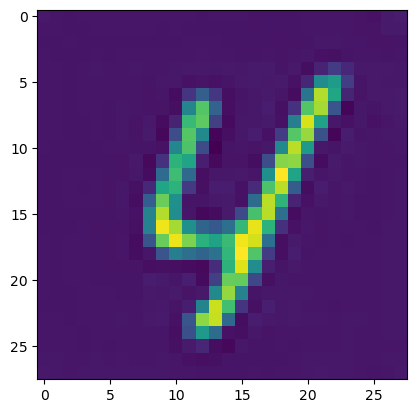

Epoch [5/20], Train Loss: 0.0875, Val Loss: 0.0882


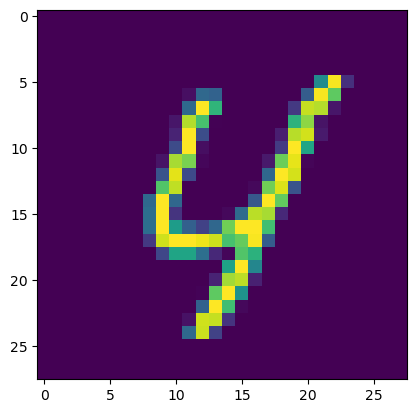

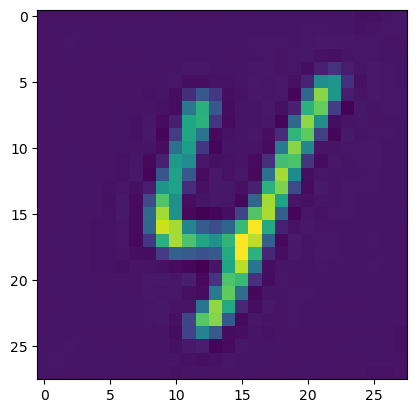

Epoch [6/20], Train Loss: 0.0850, Val Loss: 0.0739


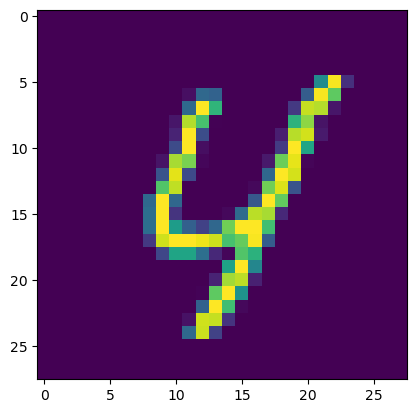

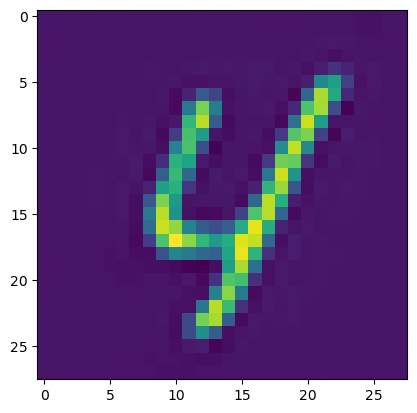

Epoch [7/20], Train Loss: 0.0829, Val Loss: 0.0924


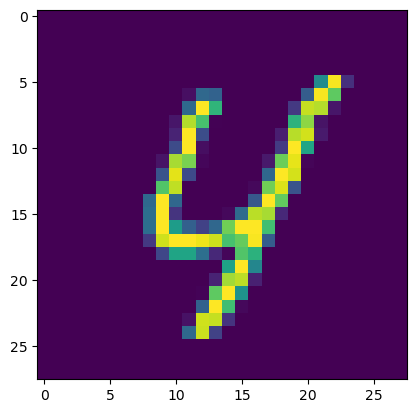

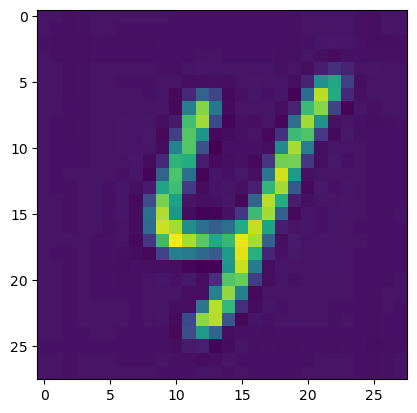

Epoch [8/20], Train Loss: 0.0809, Val Loss: 0.0774


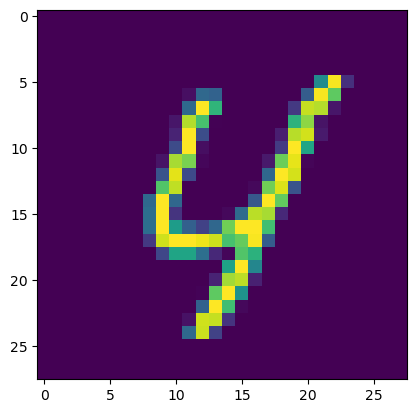

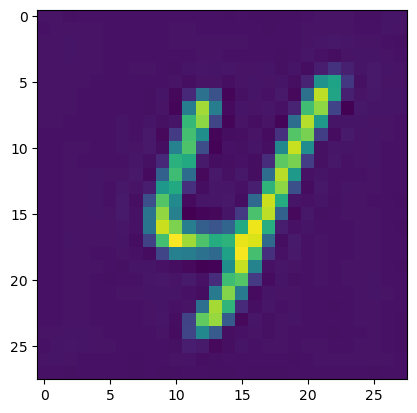

Epoch [9/20], Train Loss: 0.0805, Val Loss: 0.0846


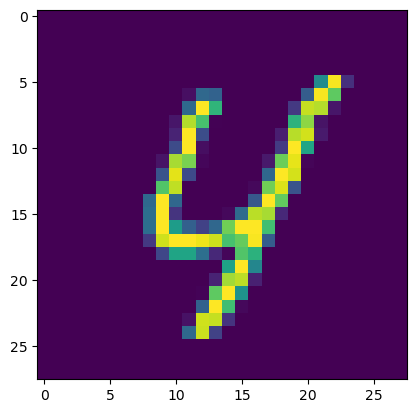

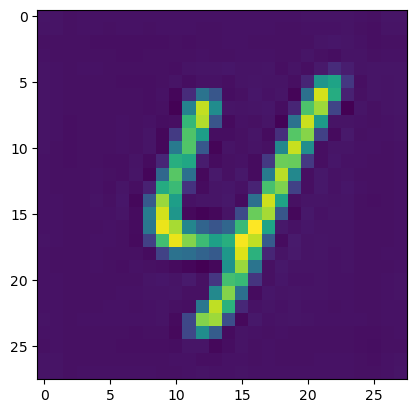

Epoch [10/20], Train Loss: 0.0790, Val Loss: 0.0748


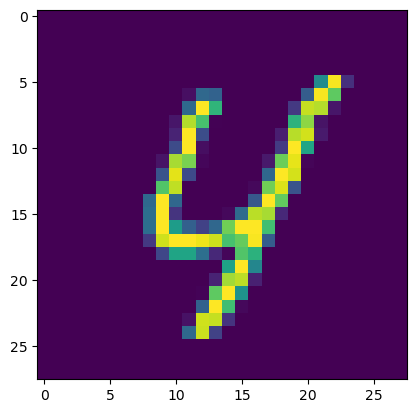

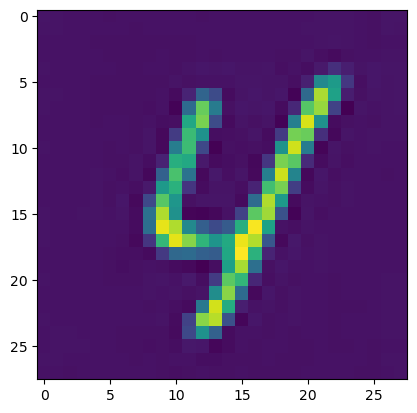

Epoch [11/20], Train Loss: 0.0781, Val Loss: 0.0756


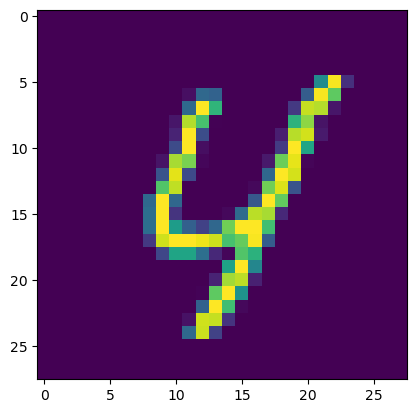

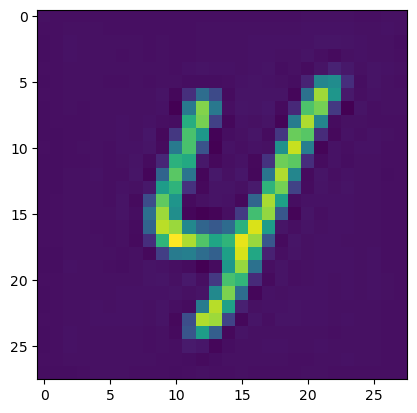

Epoch [12/20], Train Loss: 0.0762, Val Loss: 0.0762


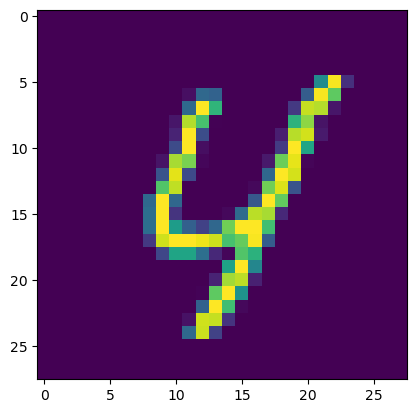

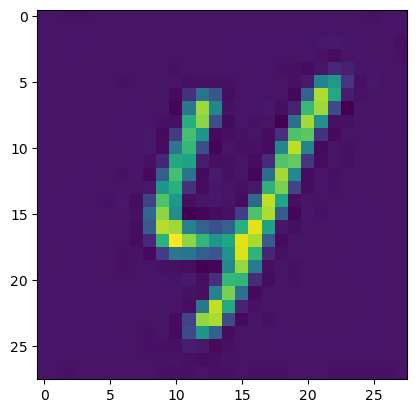

Epoch [13/20], Train Loss: 0.0762, Val Loss: 0.0789


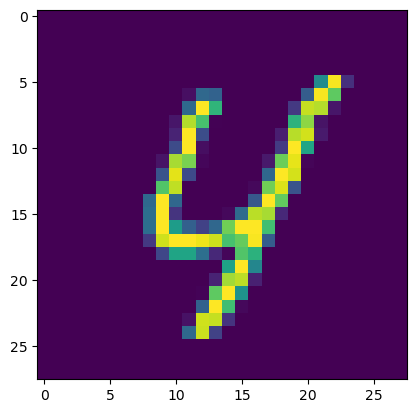

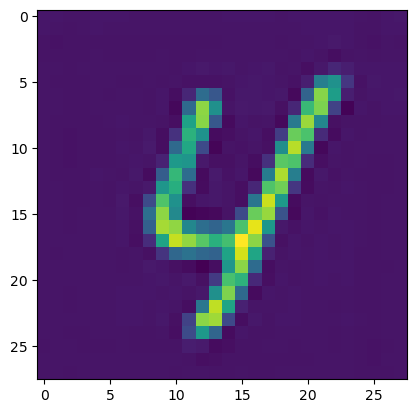

Epoch [14/20], Train Loss: 0.0744, Val Loss: 0.0773


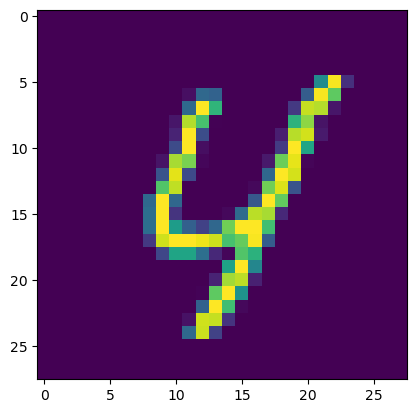

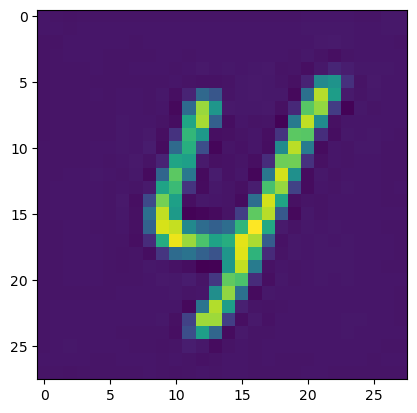

Epoch [15/20], Train Loss: 0.0737, Val Loss: 0.0671


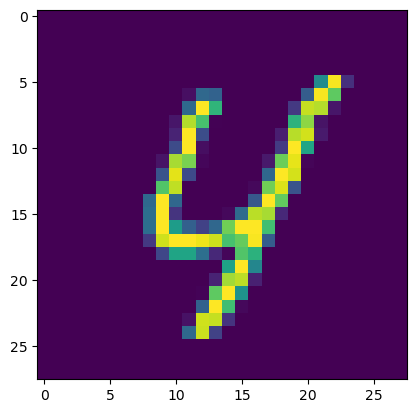

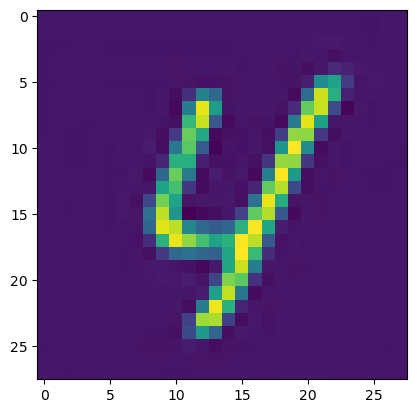

Epoch [16/20], Train Loss: 0.0732, Val Loss: 0.0646


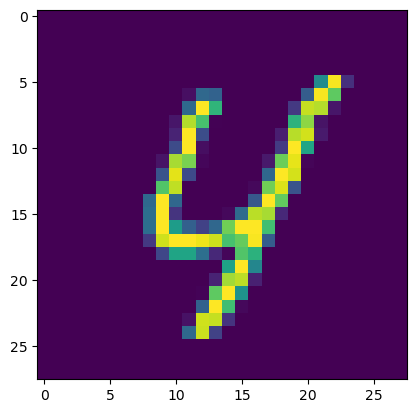

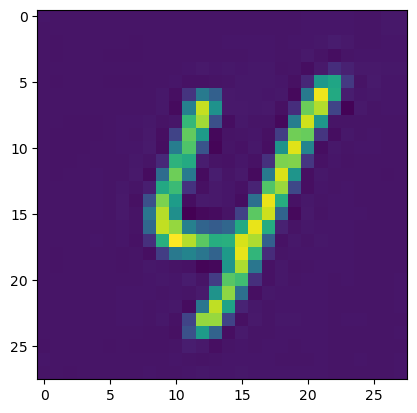

Epoch [17/20], Train Loss: 0.0728, Val Loss: 0.0733


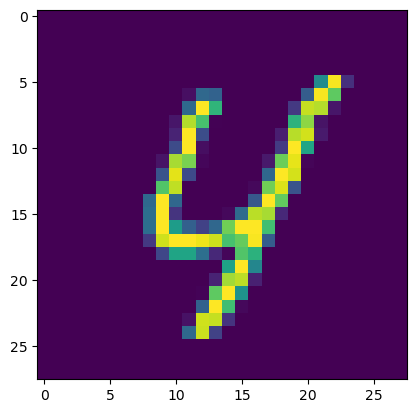

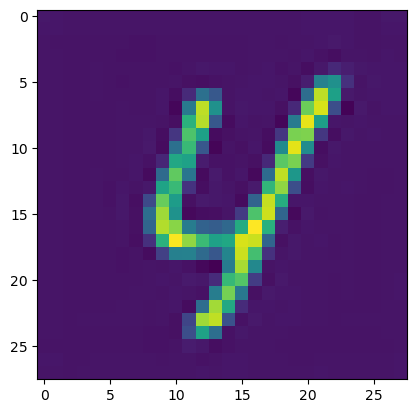

Epoch [18/20], Train Loss: 0.0721, Val Loss: 0.0734


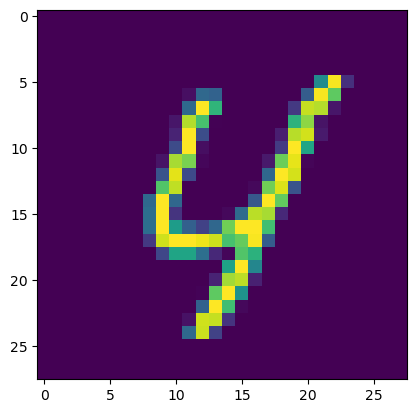

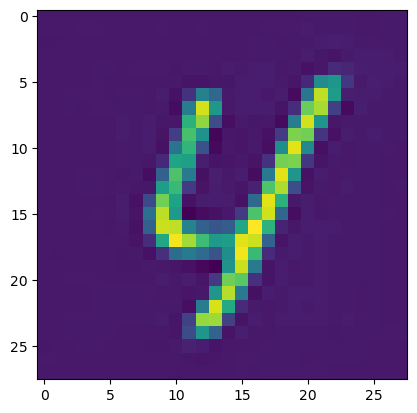

Epoch [19/20], Train Loss: 0.0710, Val Loss: 0.0770


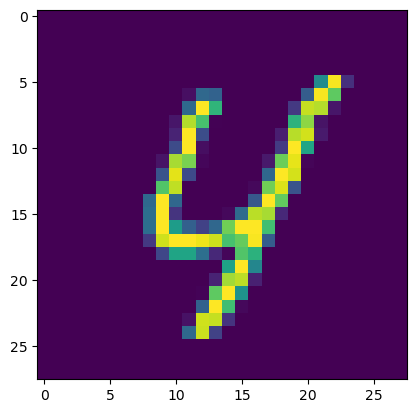

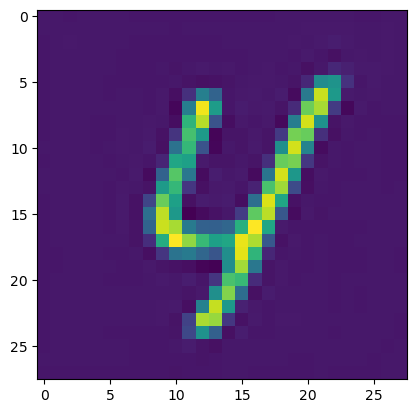

Epoch [20/20], Train Loss: 0.0709, Val Loss: 0.0743


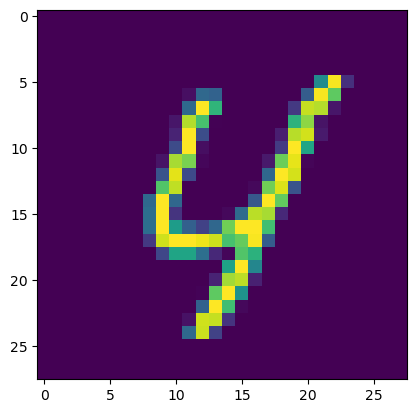

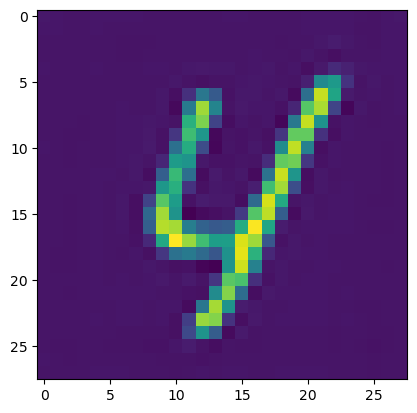

In [44]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    
    train_loss += train_model(trainloader, model)
    test_loss += validate_model(testloader, model)

    train_losses.append(train_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))
       
    print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')
    
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

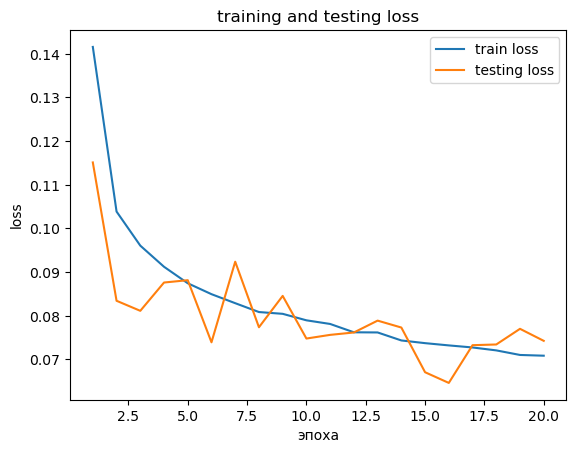

In [45]:
plt.plot(range(1, n_epochs+1), train_losses, label='train loss')
plt.plot(range(1, n_epochs+1), test_losses, label='testing loss')
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('training and testing loss')
plt.legend()
plt.show()

**Задание2 - обучить VAE собственной архитектуры**

In [47]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

In [65]:
def train_model_vae(train_dataloader, model):
  train_loss = 0

  model.train()
    
  for i, batch in enumerate(train_dataloader):
    inputs, labels = batch
    optim.zero_grad()

    predict, mu, sigma = model(inputs.to(device))
    loss = loss_func(inputs.to(device), predict) + 0.1 * kl_loss(mu, sigma)

    loss.backward()
    optim.step()

    train_loss += loss.item()

  return train_loss

In [66]:
def validate_model_vae(test_dataloader, model):
  test_loss = 0

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        inputs, labels = batch
        predict, mu, sigma = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict) + 0.1 * kl_loss(mu, sigma)

        test_loss += loss.item()

  return test_loss
    

In [71]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, padding=2) # 28x28    
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1) # 14x14   
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(0.1)
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1) # 14x14   
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.do3 = nn.Dropout(0.1)
    
    self.pool2 = nn.MaxPool2d(2, 2) # 7x7    
        
    self.conv_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.do2(self.activ(self.bn2(self.conv2(x))))
    x = self.pool2(self.do3(self.activ(self.bn3(self.conv3(x)))))
    
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=5, stride=1, padding=2)    
    self.do1 = nn.Dropout(0.2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)  
    self.do2 = nn.Dropout(0.1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14

    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)    
    self.do3 = nn.Dropout(0.2)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    
    self.conv4 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, padding=2)
    
    self.activ = nn.LeakyReLU()
    

  def forward(self, x):
    x = self.do1(self.bn1(self.activ(self.conv1(x))))
    x = self.upsample1(self.bn2(self.do2(self.activ(self.conv2(x)))))
    x = self.upsample2(self.bn3(self.do3(self.activ(self.conv3(x)))))

    return self.conv4(x)


def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

In [72]:


model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE


Epoch [1/20], Train Loss: 0.1924, Val Loss: 0.1486


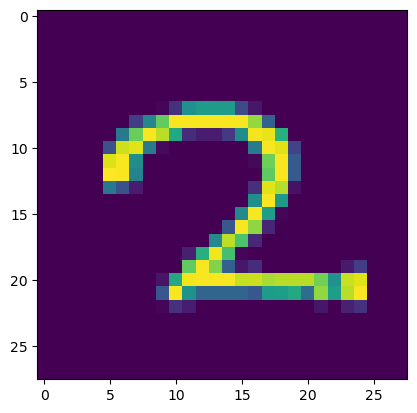

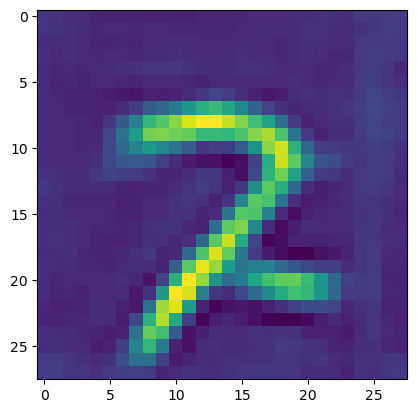

Epoch [2/20], Train Loss: 0.1399, Val Loss: 0.1326


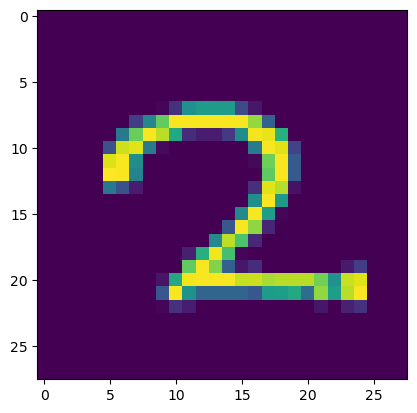

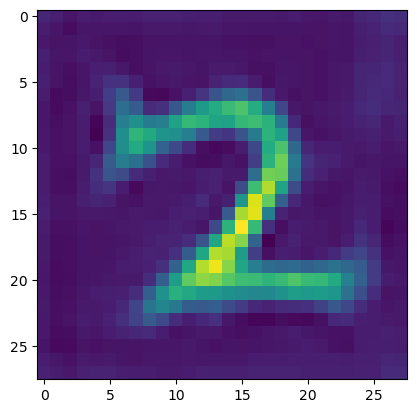

Epoch [3/20], Train Loss: 0.1341, Val Loss: 0.1353


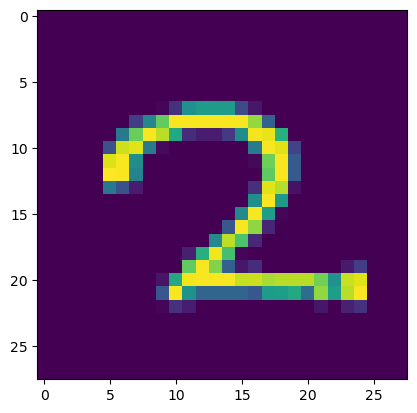

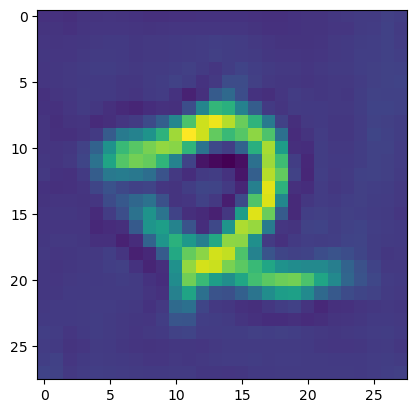

Epoch [4/20], Train Loss: 0.1305, Val Loss: 0.1261


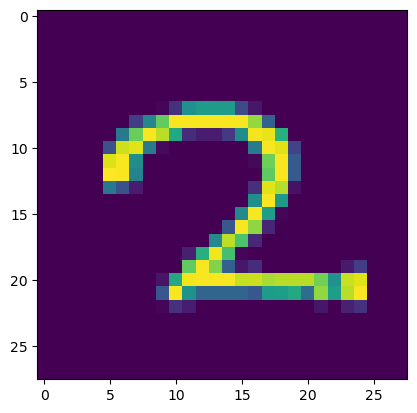

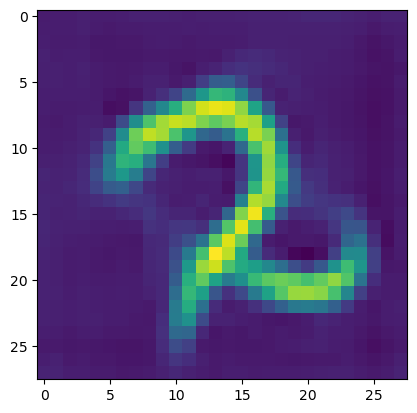

Epoch [5/20], Train Loss: 0.1285, Val Loss: 0.1231


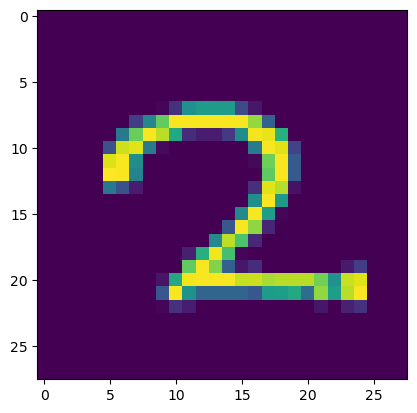

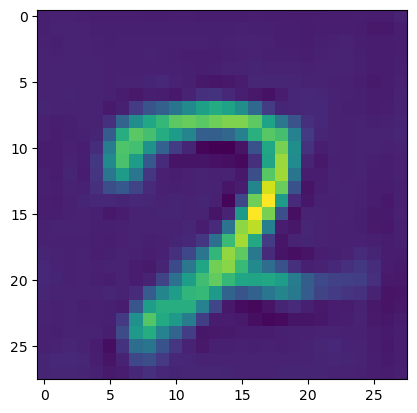

Epoch [6/20], Train Loss: 0.1267, Val Loss: 0.1236


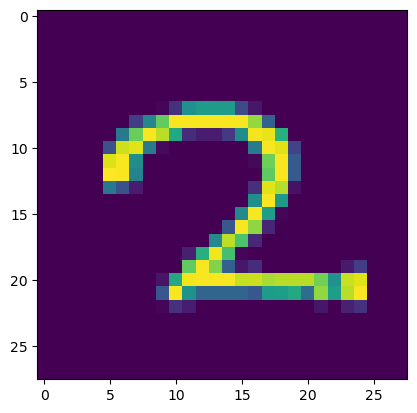

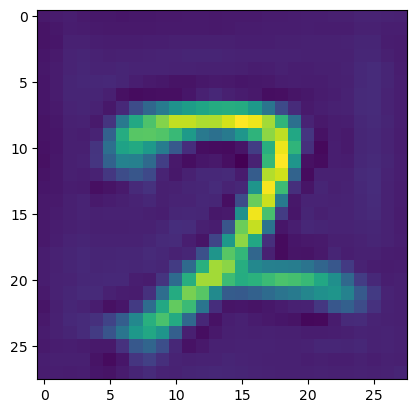

Epoch [7/20], Train Loss: 0.1251, Val Loss: 0.1190


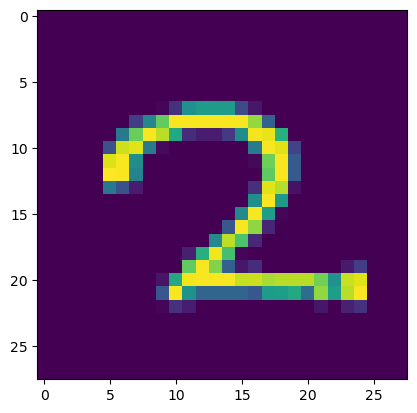

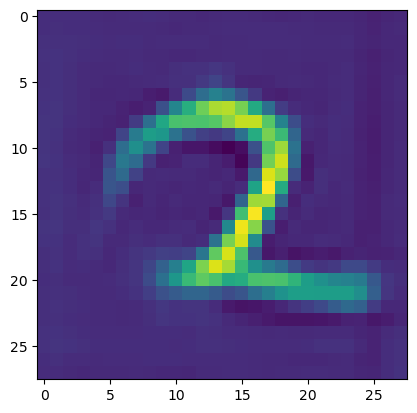

Epoch [8/20], Train Loss: 0.1242, Val Loss: 0.1208


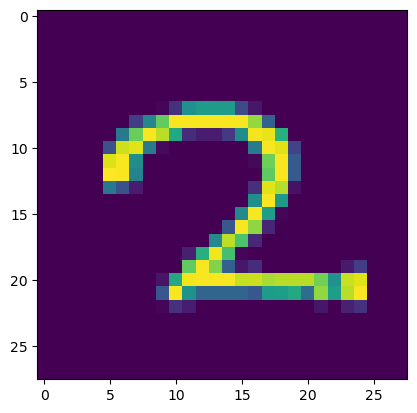

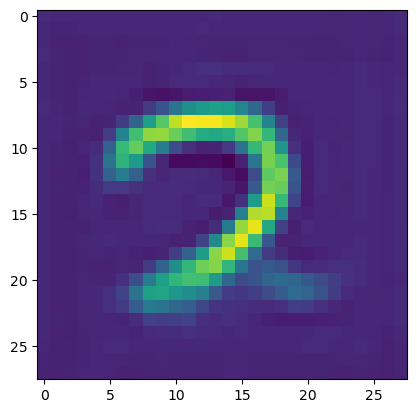

Epoch [9/20], Train Loss: 0.1231, Val Loss: 0.1197


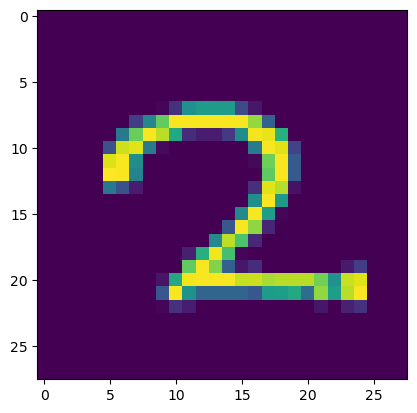

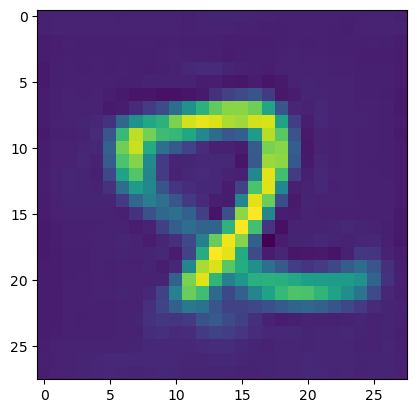

Epoch [10/20], Train Loss: 0.1223, Val Loss: 0.1184


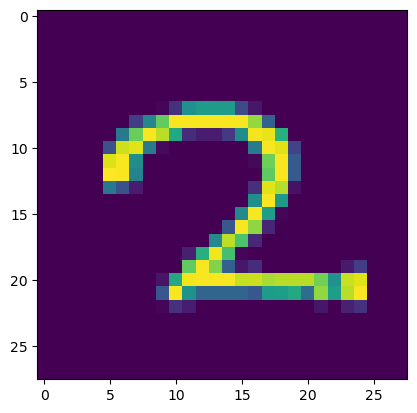

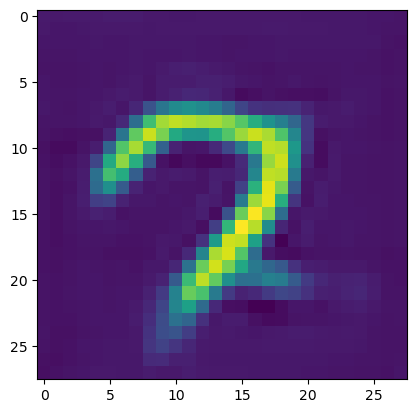

Epoch [11/20], Train Loss: 0.1217, Val Loss: 0.1189


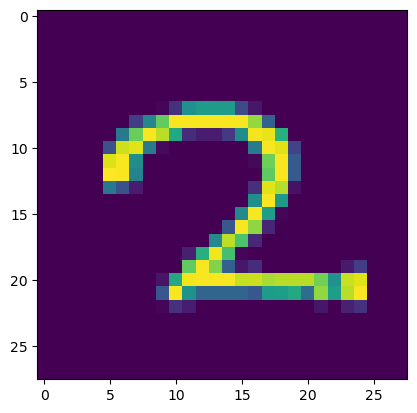

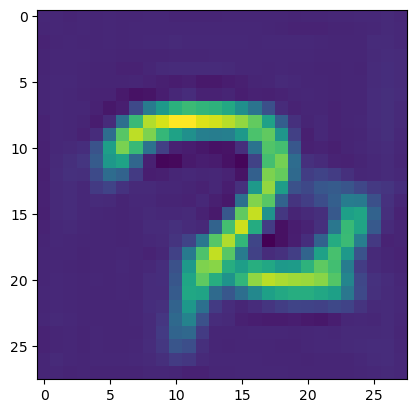

Epoch [12/20], Train Loss: 0.1209, Val Loss: 0.1164


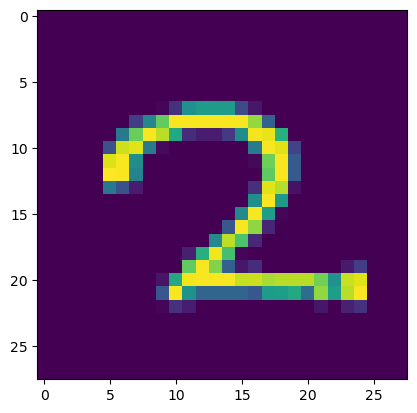

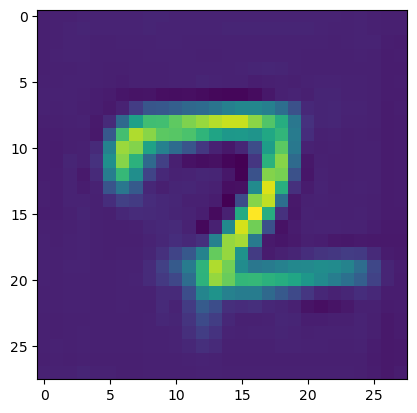

Epoch [13/20], Train Loss: 0.1204, Val Loss: 0.1171


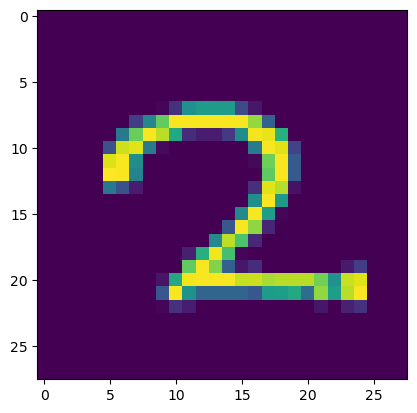

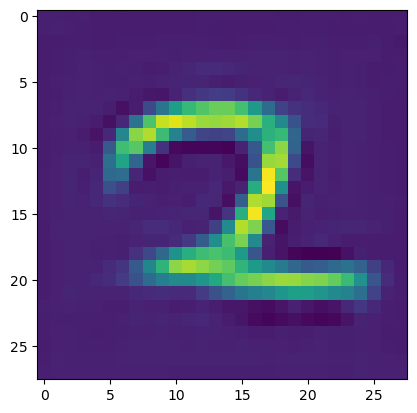

Epoch [14/20], Train Loss: 0.1199, Val Loss: 0.1154


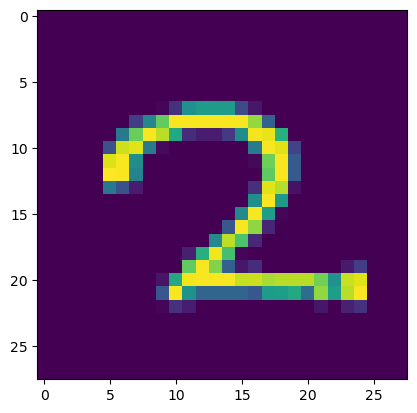

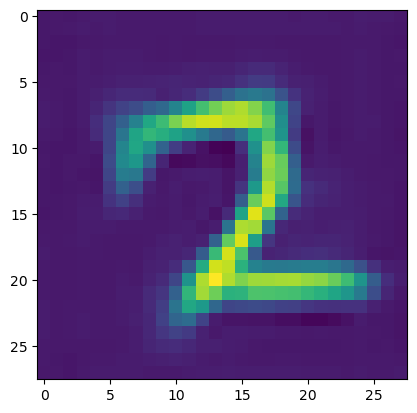

Epoch [15/20], Train Loss: 0.1196, Val Loss: 0.1174


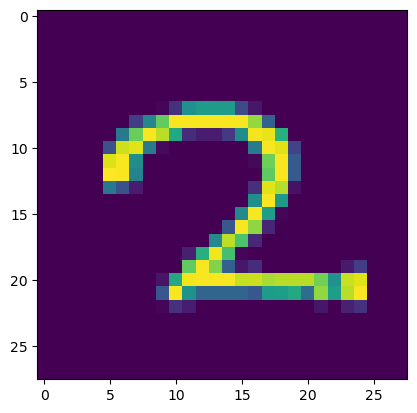

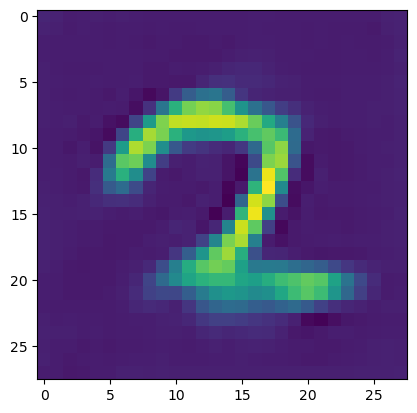

Epoch [16/20], Train Loss: 0.1191, Val Loss: 0.1168


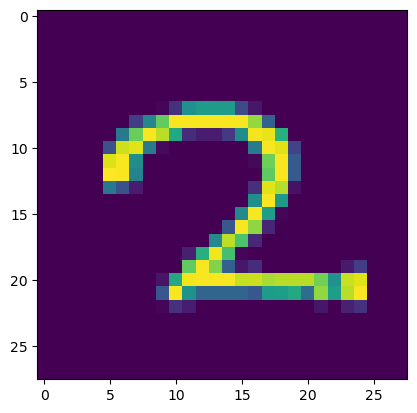

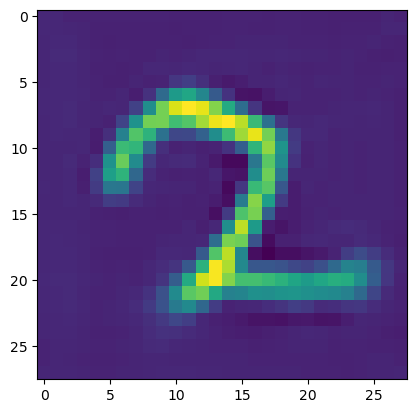

Epoch [17/20], Train Loss: 0.1187, Val Loss: 0.1150


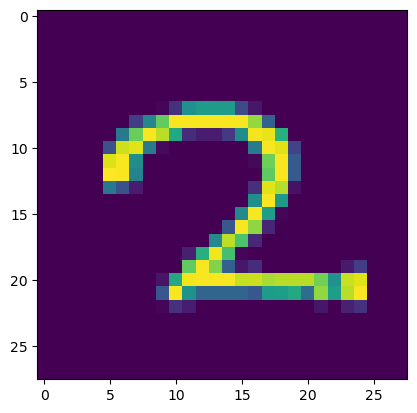

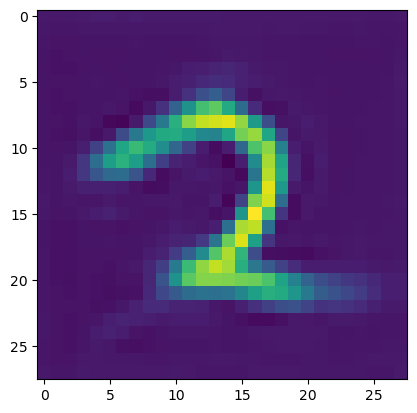

Epoch [18/20], Train Loss: 0.1186, Val Loss: 0.1159


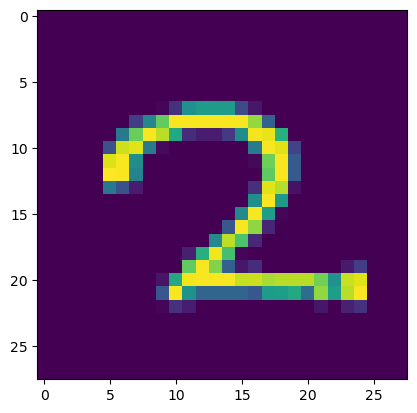

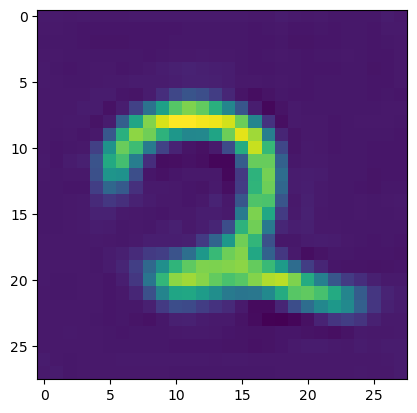

In [ ]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    
    train_loss += train_model_vae(trainloader, model)
    test_loss += validate_model_vae(testloader, model)

    train_losses.append(train_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))
       
    print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')
    
    item = dataset_test[77][0].unsqueeze(0).to(device).float()
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

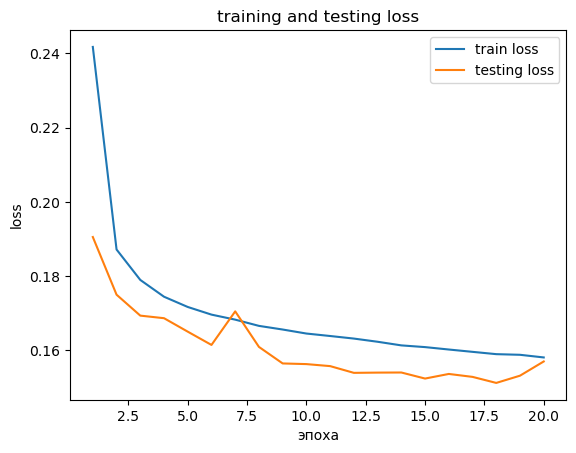

In [70]:
plt.plot(range(1, n_epochs+1), train_losses, label='train loss')
plt.plot(range(1, n_epochs+1), test_losses, label='testing loss')
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('training and testing loss')
plt.legend()
plt.show()

In [18]:
item = dataset_test[77][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)
print(mu, sigma)

tensor([[[[-0.0046,  0.0345, -0.0479,  0.2711,  0.1387, -0.0770, -0.0217],
          [-0.0522,  0.3252,  1.1395,  0.3050,  0.9147,  0.8804, -0.0288],
          [ 0.0763, -0.2659, -0.9876, -0.5564, -0.5013,  0.5982,  0.1843],
          [ 0.2003, -1.5795,  1.1329,  1.8911, -0.5187,  0.1857,  0.1705],
          [ 0.1063,  0.5439,  1.2247, -0.1655,  0.1917,  1.5917, -0.0252],
          [-0.0132,  0.4895, -0.2186, -0.9822, -0.3352, -1.2743, -1.4522],
          [-0.0310,  0.1475,  0.6533,  1.0263,  0.6943,  0.4479, -0.1111]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>) tensor([[[[0.9848, 0.9901, 0.9610, 0.9233, 0.9562, 1.0086, 1.0091],
          [0.9726, 0.8457, 0.4827, 0.3790, 0.4492, 0.6088, 0.9712],
          [0.9342, 0.4155, 0.4227, 0.4469, 0.4220, 0.3193, 0.9410],
          [0.7974, 0.4084, 0.4357, 0.4244, 0.3954, 0.3273, 0.9338],
          [0.9231, 0.6790, 0.4905, 0.3241, 0.3274, 0.4826, 0.7807],
          [0.9515, 0.7137, 0.3641, 0.4101, 0.4530, 0.4462, 0.5860],
        

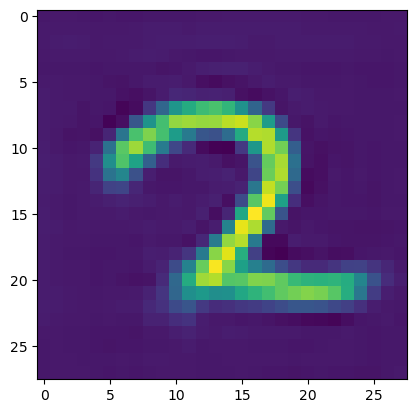

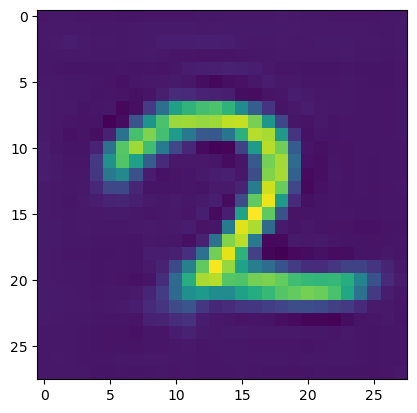

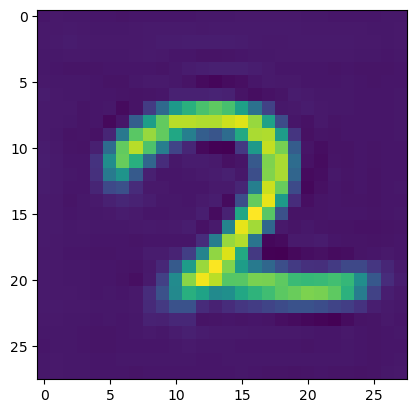

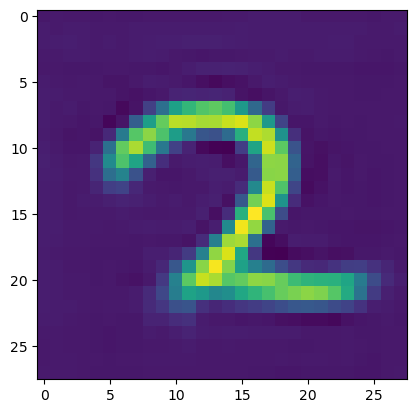

In [19]:

for _ in range(4):
    hid = torch.normal(mu.cpu(), sigma.cpu()*0.1).to(device)

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()